In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta 

nobs = 180
theta = 0.3
Y = np.random.binomial(1, theta, nobs)
Y

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0])

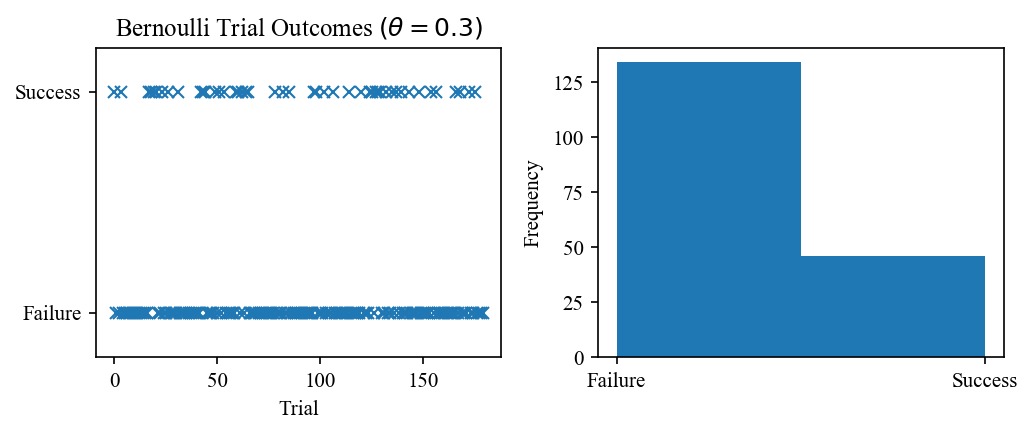

In [184]:
fig,ax = plt.subplots(1,2,figsize=(7,3),dpi=150)
# gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = ax[0]
ax2 = ax[1]

ax1.plot(range(nobs), Y, 'x')
ax2.hist(Y, bins=2)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.3)$', xlabel='Trial', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()

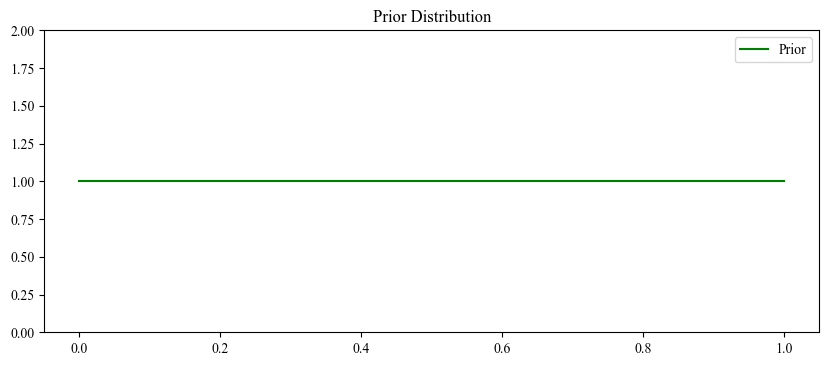

In [185]:
# Beta distribution
fig = plt.figure(figsize=(10,4),dpi=100)
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
a1=1
a2=1

ax.plot(X, beta(a1, a2).pdf(X), 'g')

# Cleanup
ax.set(title='Prior Distribution', ylim=(0,2))
ax.legend(['Prior'])

In [186]:
Y.sum()/len(Y),X[beta(Y.sum(), len(Y)-Y.sum()).pdf(X).argmax()]

(0.25555555555555554, 0.25325325325325326)

$$
\begin{aligned}
p(\theta|Y;\alpha_1,\alpha_2) & = \frac{P(Y|\theta) P(\theta)}{P(Y)} \\
& \propto P(Y|\theta) P(\theta) \\
& = \theta^s (1-\theta)^{T-s} \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1} \\
& \propto \theta^{s+\alpha_1-1} (1 - \theta)^{T-s+\alpha_2 - 1} \\
\end{aligned}$$

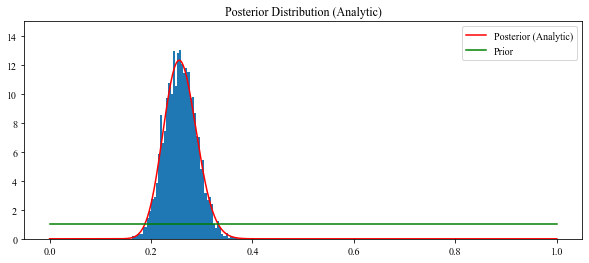

In [187]:
# Metropolis-Hastings parameters
from scipy.special import gamma

# Create the function symbolically
likelihood = lambda t,T,s: (t**s)*(1-t)**(T-s)
G1 = 1000 # burn-in period
G = 10000 # draws from the (converged) posterior

# Model parameters
sigma = 0.1
thetas = [0.5]             # initial value for theta
etas = np.random.normal(0, sigma, G1+G) # 先采样一个大的向量
unif = np.random.uniform(size=G1+G)     # comparators for accept_probs

# Callable functions for likelihood and prior
prior_const = gamma(a1) * gamma(a2) / gamma(a1 + a2)
mh_ll = lambda theta: likelihood(theta, nobs, Y.sum()) # 序列出现的概率 正比 没有系数
def mh_prior(theta):
    prior = 0
    if theta >= 0 and theta <= 1:
        prior = prior_const*(theta**(a1-1))*((1-theta)**(a2-1))
    return prior
mh_accept = lambda theta: mh_ll(theta) * mh_prior(theta) # 求乘积

theta_prob = mh_accept(thetas[-1])

# Metropolis-Hastings iterations
for i in range(G1+G):
    # Draw theta
    
    # Generate the proposal
    theta = thetas[-1]
    theta_star = theta + etas[i]
    theta_star_prob = mh_accept(theta_star)
    # Calculate the acceptance probability
    accept_prob = theta_star_prob / theta_prob
    
    # Append the new draw
    if accept_prob > unif[i]:
        theta = theta_star #新样本
        theta_prob = theta_star_prob
    thetas.append(theta)
# Find the hyperparameters of the posterior
a1_hat = a1 + Y.sum()
a2_hat = a2 + nobs - Y.sum()

# Posterior Mean
post_mean = a1_hat / (a1_hat + a2_hat)

# Plot the analytic posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, beta(a1_hat, a2_hat).pdf(X), 'r')

# Plot the prior
ax.plot(X, beta(a1, a2).pdf(X), 'g')
ax.hist(thetas[G1:], bins=50,density=True)
# Cleanup
ax.set(title='Posterior Distribution (Analytic)', ylim=(0,15))
ax.legend(['Posterior (Analytic)', 'Prior'])